In [1]:
import qutip as qt
import numpy as np
from IPython.display import display, Math
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from utils import pprint, plot_bloch
from qutip import Bloch


ModuleNotFoundError: No module named 'utils'

## Formatting for printing

In [2]:
def format_complex(number, digits=3):
    """Format a complex number into LaTeX style string with i instead of j."""
    re, im = np.real(number), np.imag(number)
    out = ""
    
    # if np.isclose(number, 0):
    #     return "0"
    
    if not np.isclose(re, 0): # real part
        out += f"{re:.{digits}f}"
    if not np.isclose(im, 0): # imag part
        sign = "-" if im < 0 else ("+" if re > 0 else "") # adds sign if non-zero
        out += f"{sign} i{abs(im):.{digits}f}"
        
    return out


def _add_parenthesis(number, digits=3):
    """Return formatted complex number, wrapped in parentheses if both parts nonzero."""
    re, im = number.real, number.imag

    if np.isclose(re, 0) and np.isclose(im, 0):
        return None, None

    formatted = format_complex(number, digits)

    if not np.isclose(re, 0) and not np.isclose(im, 0):
        return f"({formatted})", True

    return formatted, False

def prettyprint(label, state, digits=3):
    """Pretty-print a state as LaTeX."""
    if isinstance(state, qt.Qobj):
        state = state.full().ravel()
    elif isinstance(state, np.ndarray):
        state = state.ravel()
    elif isinstance(state, (int, float, complex)):
        return display(Math(label + format_complex(state, digits)))
    else:
        raise TypeError(
            f"state must be qutip.Qobj, numpy.ndarray, int, float, or complex, not {type(state)}"
        )

    if len(state) != 2:
        raise ValueError("prettyprint currently only supports 2D states.")

    zero, one = state
    ket0, ket1 = r"\ket{0}", r"\ket{1}"
    total = label

    zero_str, zero_par = _add_parenthesis(zero, digits)
    one_str, one_par = _add_parenthesis(one, digits)
    print(f"{one_str = }")
    if zero_str is not None:
        total += zero_str + ket0

    if one_str is not None:
        # If parentheses OR no explicit sign
        if one_par or (not one_str[0] in "+-"):
            total += "+" + one_str + ket1
        else:
            total += one_str + ket1

    display(Math(total))
    

## Plotting Bloch sphere using `plotly`

In [ ]:
def plot_bloch_plotly(states, labels=None, colors=None, show_axes=True):
    """
    Plot one or more qubit states on an interactive Plotly Bloch sphere.
    
    Parameters:
    - states : list of qutip.Qobj or single qutip.Qobj
        The quantum states to plot (kets).
    - labels : list of str, optional
        Labels for the states for legend and hover text.
    - colors : list of str, optional
        Colors for each state.
    - show_axes : bool, optional (default True)
        Show X, Y, and Z axis
    """
    # Ensure list
    if not isinstance(states, list):
        states = [states]
    n = len(states)

    if labels is None:
        labels = [f"ψ{i+1}" for i in range(n)]
    if colors is None:
        # Use Plotly qualitative palette
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan'][:n]

    # Convert states to Bloch vectors
    def bloch_vector(state):
        rho = qt.ket2dm(state)
        x = np.real(qt.expect(qt.sigmax(), rho))
        y = np.real(qt.expect(qt.sigmay(), rho))
        z = np.real(qt.expect(qt.sigmaz(), rho))
        return np.array([x, y, z])

    vectors = [bloch_vector(s) for s in states]

    # Sphere surface
    u = np.linspace(0, 2*np.pi, 50)
    v = np.linspace(0, np.pi, 25)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))

    sphere = go.Surface(
        x=xs, y=ys, z=zs,
        opacity=0.2,
        showscale=False,
        colorscale="Blues",
        name="Bloch Sphere"
    )

    # Add state vectors
    vec_traces = []
    for vec, label, color in zip(vectors, labels, colors):
        vec_traces.append(
            go.Scatter3d(
                x=[0, vec[0]],
                y=[0, vec[1]],
                z=[0, vec[2]],
                mode="lines+markers+text",
                marker=dict(size=5, color=color),
                line=dict(width=6, color=color),
                text=[None, label],
                textposition="top center",
                name=label
            )
        )

    # Add |0> and |1> basis markers
    basis_markers = go.Scatter3d(
        x=[0, 0],
        y=[0, 0],
        z=[1, -1],
        mode="markers+text",
        marker=dict(size=6, color="black"),
        text=["|0⟩", "|1⟩"],
        textposition="top center",
        name="Basis states"
    )
    axis_traces = []
    if show_axes:
        axis_traces = [
            # X-axis
            go.Scatter3d(x=[0,1], y=[0,0], z=[0,0],
                         mode='lines+text',
                         line=dict(color='gray', width=3),
                         text=["", "X"], textposition="top center",
                         name="X axis"),
            # Y-axis
            go.Scatter3d(x=[0,0], y=[0,1], z=[0,0],
                         mode='lines+text',
                         line=dict(color='gray', width=3),
                         text=["", "Y"], textposition="top center",
                         name="Y axis"),
            # Z-axis
            go.Scatter3d(x=[0,0], y=[0,0], z=[0,1],
                         mode='lines+text',
                         line=dict(color='gray', width=3),
                         text=["", ""], textposition="top center",
                         name="Z axis"),
        ]

    # Layout
    layout = go.Layout(
        scene=dict(
            xaxis=dict(range=[-1, 1]),
            yaxis=dict(range=[-1, 1]),
            zaxis=dict(range=[-1, 1]),
            aspectmode="cube"
        ),
        legend=dict(x=0.8, y=0.9)
    )

    fig = go.Figure(data=[sphere] + vec_traces + [basis_markers] + axis_traces, layout=layout)
    fig.show()


# (1) Qubit states and overlap

Find the overlap $\braket{\psi\vert\phi}$ of the two qubit states 
$$
\begin{align}
\ket{\psi} &= \sqrt{\frac{1}{3}}\ket{0} + i\sqrt{\frac{2}{3}}\ket{1} \\
\ket{\phi} &= \sqrt{\frac{1}{3}}\ket{0} + \sqrt{\frac23}\ket{1} 
\end{align}
$$

In [24]:
zero = qt.basis(2, 0)
one = qt.basis(2, 1)
# psi = 1j*np.sqrt(2/3)*one
psi = np.sqrt(1/3)*zero + 1j*np.sqrt(2/3)*one
phi = np.sqrt(1/3)*zero + np.sqrt(2/3)*one

res = psi.dag() * phi
prettyprint(r"\ket\psi =", psi)
prettyprint(r"\ket\phi =", phi)
prettyprint(r"\braket{\psi|\phi} =", res)


one_str = ' i0.816'


<IPython.core.display.Math object>

one_str = '0.816'


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [25]:
plot_bloch_plotly([psi, phi], labels=["ψ", "φ"], colors=["red", "blue"])

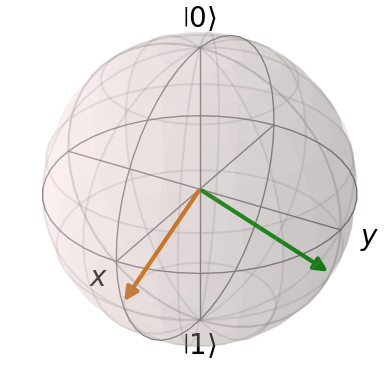

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b = Bloch(fig=fig, axes=ax)
b.add_states(psi)
b.add_states(phi)
b.render()